In [1]:
import logging
import sys

import matplotlib.pyplot as plt

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import sys

sys.path.append('../scripts')
sys.path.append('../')
from scripts import centroids_graph_builder
from time import sleep
from multiprocessing import Pool

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import graph_osm_loader, utils

import networkx as nx

from heapq import heappop, heappush
from itertools import count
from scripts import clustering

2024-12-09 21:25:46,421 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
def get_rand_graph(N, p):
    G = nx.fast_gnp_random_graph(N, p, directed=False)
    if not nx.is_connected(G):
        tmp = []
        for n in nx.connected_components(G):
            for q in n:
                tmp.append(q)
                break
        for i in range(len(tmp) - 1):
            G.add_edge(tmp[i], tmp[i + 1])
    for e in G.edges:
        G.add_edge(e[0], e[1], length=np.random.random_sample() + 0.001)
    for u in G.nodes:
        if u in G[u]:
            G.remove_edge(u, u)
    return G

In [4]:
NUM_ITERATION = 10  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 5  # количество потоков

In [5]:
GRAPH_ID = 'R2555133'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # загрузка графа
N = 10000
p = 3 / N
# g = get_rand_graph(N,p)
# g = get_graph()
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

17923 27016


In [6]:
g.remove_edges_from(nx.selfloop_edges(g))

In [7]:
cms = clustering.resolve_k_means_communities(g, resolution=10, max_iteration=100, cluster_name='cluster',
                                             print_log=True)
print(len(cms))

2024-12-09 21:25:50,440 - root - INFO - communities: 504


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]

504


In [8]:
cls2hubs = {}
cls2n = centroids_graph_builder.get_cls2n(g)
for i, c in enumerate(cms):
    for j in cls2n[i]:
        if (i, j) in cls2hubs:
            continue
        a = set()
        b = set()
        for u in c:
            for v in g[u]:
                if v in cms[j]:
                    a.add(u)
                    b.add(v)
        cls2hubs[i, j] = a if len(a) < len(b) else b
        cls2hubs[j, i] = a if len(a) < len(b) else b

In [9]:
cls2hub = {}  # = centroids_graph_builder.get_cls2hubs(g)
for i, j in cls2hubs:
    if i not in cls2hub:
        cls2hub[i] = set()
    cls2hub[i].update(cls2hubs[i, j])
del cls2hubs

In [10]:
hubs = set([u for v in cls2hub.values() for u in v])

In [11]:
hub2id = {h: i for i, h in enumerate(hubs)}
id2hub = {i: h for i, h in enumerate(hubs)}

In [12]:
len(set(hubs))

2720

In [13]:
def dijkstra_pfa_to_set(graph: nx.Graph,
                        start: int,
                        ends: set[int]
                        ) -> \
        tuple[float, list[int]]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []

    dist[start] = 0.0
    push(fringe, (0.0, next(c), start))
    visited = set()
    
    while fringe:
        (d, _, v) = pop(fringe)
        if v in ends:
            visited.add(v)
        if len(visited) == len(ends):
            break
        
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist or dist[u] > vu_dist:
                dist[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
    return dist


In [14]:
def cals(data_partitions):
    part, hubs, l = data_partitions
    dst = np.zeros((l, l))

    for u in part:
        dst_u = dijkstra_pfa_to_set(g, u, hubs)
        for v in hubs:
            dst[hub2id[u], hub2id[v]] = dst_u[v]
    return dst


data = [(list(hubs)[i::WORKER], hubs, len(hubs)) for i in range(WORKER)]
with Pool(WORKER) as p:
    dst = sum(tqdm(p.imap_unordered(cals, data), total=len(data)))

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
def cals(data_partitions):
    part, l = data_partitions
    res = {}
    for u in part:
        dst_u = dijkstra_pfa_to_set(g, u, cls2hub[g.nodes()[u]['cluster']])
        for v in cls2hub[g.nodes()[u]['cluster']]:
            res[u, v] = dst_u[v]
    return res

data = [(list(g.nodes)[i::WORKER], hubs) for i in range(WORKER)]
with Pool(WORKER) as p:
    d_nodes = {k: v for d in tqdm(p.imap_unordered(cals, data), total=len(data)) for k, v in d.items()}

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
from pympler.asizeof import asizeof
asizeof(d_nodes)/1024/1024, asizeof(dst)/1024/1024

(42.56950378417969, 56.44544982910156)

In [17]:
def dijkstra_pfa_cls(g, u, v):
    nodes = g.nodes()
    c1, c2 = nodes[u]['cluster'], nodes[v]['cluster']
    if c1 == c2:
        return nx.single_source_dijkstra(g, u, v, weight='length')
    return min(d_nodes[u, h1] + d_nodes[v, h2] + dst[hub2id[h1], hub2id[h2]] for h1 in cls2hub[c1] for h2 in cls2hub[c2]), []

In [18]:
# points = [(u,v) for u in g.nodes() for v in g.nodes() if u!=v]
points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]

generate points:   0%|          | 0/1000 [00:00<?, ?it/s]

In [124]:
g_h = nx.Graph()
for u in hubs:
    g_h.add_node(u)

for u in hubs:
    for v in hubs:
        if u ==v:
            continue
        g_h.add_edge(u,v,length = dst[hub2id[u], hub2id[v]])

In [ ]:
edges = [(u,v) for u,v in g_h.edges()]
for u,v in tqdm(edges):
    d = g_h.edges()[u,v]
    g_h.remove_edge(u,v)
    if not nx.is_connected(g_h):
        g_h.add_edge(u,v,**d)
        continue
    l = nx.single_source_dijkstra(g_h, u,v, weight='length')[0]
    if abs(l-d['length']) > 0.1:
        # print(l, d['length'])
        g_h.add_edge(u,v,**d)

  0%|          | 0/3697840 [00:00<?, ?it/s]

In [ ]:
len(g_h.nodes), len(g_h.edges), len(dst) * (len(dst)-1)/2

In [ ]:
for u in g.nodes():
    ends = set(cls2hub[g.nodes()[u]['cluster']])
    d = dijkstra_pfa_to_set(g, u, ends)
    for v in ends:
        l  = nx.single_source_dijkstra(g, u,v,weight='length')[0]
        if abs(l - d[v]) >0.1:
            print(l, d[v], u,v)

In [ ]:
for h1 in tqdm(g_h.nodes):
    for h2 in g_h.nodes:
        if h1 == h2:
            continue
        l0 = nx.single_source_dijkstra(g_h, h1,h2, weight='length')[0]
        l1 = nx.single_source_dijkstra(g, h1,h2, weight='length')[0]
        if abs(l0-l1)>0.1:
            print(l0,l1)

In [101]:
def bi_dijkstra_pfa(graph: nx.Graph,
                    start: int,
                    end: int,
                    ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    
    nodes = graph.nodes()
    c1,c2 = nodes[start]['cluster'],nodes[end]['cluster']
    
    if c1 == c2:
        return nx.single_source_dijkstra(g, start, end, weight='length') 
        
    
    push = heappush
    pop = heappop
    
    dist = ({}, {})
    fringe = ([], [])
    c = count()

    d1 = dijkstra_pfa_to_set(graph, start, cls2hub[c1])
    d2 = dijkstra_pfa_to_set(graph, end, cls2hub[c2])
    
    adjacency = g_h._adj
    
    for h1 in cls2hub[c1]:
        push(fringe[0], (d1[h1], next(c), 0, h1))
        dist[0][h1] = (d1[h1], 0, None)
        
    for h2 in cls2hub[c2]:
        push(fringe[1], (d2[h2], next(c), 0, h2))
        dist[1][h2] = (d2[h2], 0, None)
        
    union_node = None
    union_dst = float('inf')
    
    while fringe[0] and fringe[1]:
        (d1, _, n1, v1) = pop(fringe[0])
        (d2, _, n2, v2) = pop(fringe[1])
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, n1 + 1, v1)
                push(fringe[0], (vu_dist, next(c), n1 + 1, u))
            if u in dist[1]:
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        for u, e in adjacency[v2].items():
            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, n2 + 1, v2)
                push(fringe[1], (vu_dist, next(c), n2 + 1, u))
            if u in dist[0]:
                dd = dist[0][u][0] + dist[1][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
        if d1 + d2 > union_dst:
            break

    # d1, n1, _ = dist[0][union_node]
    # d2, n2, _ = dist[1][union_node]
    # path = [0] * (n1 + n2 + 1)
    # e = union_node
    # i = n1
    # while dist[0][e][2] is not None:
    #     path[i] = e
    #     i -= 1
    #     e = dist[0][e][2]
    # path[0] = e
    # 
    # e = union_node
    # i = n1
    # while dist[1][e][2] is not None:
    #     path[i] = e
    #     i += 1
    #     e = dist[1][e][2]
    # path[-1] = e
    return union_dst, []


In [102]:
@utils.profile(iterations=NUM_ITERATION)
def usual_path(g, p1, p2):
    return nx.single_source_dijkstra(g, p1, p2, weight='length')


@utils.profile(iterations=NUM_ITERATION)
def h_path(g, p1, p2):
    return bi_dijkstra_pfa(g, p1, p2)


def do_calc(data_partitions):
    point_partition, worker_number = data_partitions

    stat = {
        'l': [],
        'h_l': [],
        'p': [],
        'h_p': [],
        'time_l': [],
        'time_h': [],
        'delta': []
    }

    # чисто чтобы tqdm нормально прогрузился 
    sleep(worker_number / 10)
    print('start', worker_number)

    for p1, p2 in tqdm(
            point_partition,
            desc='find paths',
            position=worker_number
    ):
        # класический дейкстра
        time_l, (l, p) = usual_path(g, p1, p2)
        # иерархический
        time_h, (h_l, h_p) = h_path(g, p1, p2)
        delta = (h_l - l) / l * 100

        stat['l'].append(l)  # длина обычного пути
        stat['h_l'].append(h_l)  # длина иерархического пути
        stat['p'].append(p)  # обычный путь
        stat['h_p'].append(h_p)  # иерархический путь
        stat['delta'].append(delta)  # разница в длине
        stat['time_l'].append(time_l)  # обычное время 
        stat['time_h'].append(time_h)  # иерархическое
    return stat


data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
# do_calc(data[0])
with Pool(WORKER) as p:
    stat = {k: v for r in p.imap_unordered(do_calc, data) for k, v in r.items()}

print(f"err_mean: {np.mean(stat['delta']):.2f} %")
print(f"err_min: {np.min(stat['delta']):.2f} %")
print(f"err_max: {np.max(stat['delta']):.2f} %", )
print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")

start 0


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 1


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 2


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 3


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 4


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

err_mean: -0.00 %
err_min: -0.00 %
err_max: 0.00 %
acceleration: 2.90 times


{'whiskers': [<matplotlib.lines.Line2D at 0x7c77dd815270>,
 'caps': [<matplotlib.lines.Line2D at 0x7c77dd8157b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c77dd814fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c77dd815cf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c77dd815f90>],
 'means': []}

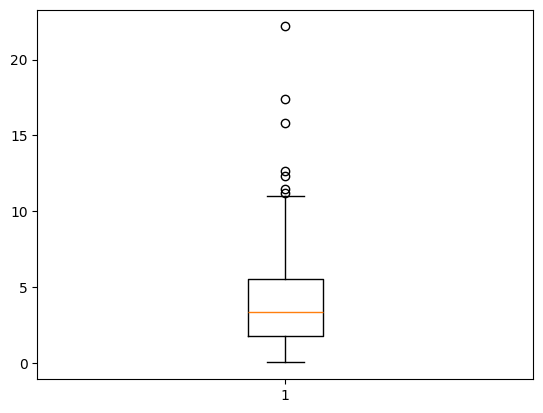

In [54]:
acceleration = np.array(stat['time_l']) / np.array(stat['time_h'])
plt.boxplot(acceleration)

In [88]:
idx = np.argmin(stat['delta'])

In [89]:
p1,p2 = stat['l'][idx], stat['h_l'][idx]

In [90]:
p1,p2

(4924.334000000002, 60.248)

In [91]:
p = stat['p'][idx]


In [93]:
u,v = p[0],p[-1]

In [97]:
u,v

(2028392726, 5306952854)

In [99]:
bi_dijkstra_pfa(g, u,v)

2028474171 214.046
1576825122 597.7919999999999
1576824995 1076.319
1289849091 947.9459999999999
1576825125 474.258
1576825062 447.144
1576825093 531.79
2028392584 598.596
2028392778 174.832
2028392753 220.211
1336309426 1134.943
1576825011 997.179
2028392633 1098.565
2028392699 1205.836
2028392735 623.679
2383149392 312.483
5306952854 0.0
1585803311 30.124


(60.248, [])